In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import warnings
warnings.filterwarnings('ignore')
from typing import Dict, Any, Optional, Tuple
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('WTCM.csv')

In [3]:
data

,Unnamed: 0,Date,High,Low,Open,Close,Volume
0,0,1546498800,7.06,7.00,7.06,7.00,600
1,1,1546516800,7.42,7.28,7.28,7.42,2800
2,2,1546603200,7.42,7.38,7.38,7.42,900
3,3,1546941600,7.32,7.20,7.32,7.20,45200
4,4,1546945200,7.28,7.22,7.22,7.28,25100
...,...,...,...,...,...,...,...
13246,13246,1764774000,13.70,13.68,13.68,13.68,700
13247,13247,1764777600,13.76,13.70,13.70,13.70,22100
13248,13248,1764781200,13.80,13.80,13.80,13.80,600
13249,13249,1764788400,13.96,13.78,13.82,13.78,16900


Тесты на стационарность

напишем, класс для тестирования стационарности временных рядов с функцией визуализацией и тестами

In [ ]:
class StationarityTester:
    """
    Методы:
    1. ADF тест (Augmented Dickey-Fuller)
    2. KPSS тест (Kwiatkowski-Phillips-Schmidt-Shin)
    3. PP тест (Phillips-Perron)
    4. Визуализация
    """
    
    def __init__(self, alpha: float = 0.05):
        self.alpha = alpha
        self.results = {}
        self.data = data
        
    def adf_test(self, series: pd.Series, 
                 regression: str = 'c',
                 maxlag: Optional[int] = None,
                 autolag: str = 'AIC') -> Dict[str, Any]:
        """
        Augmented Dickey-Fuller тест на единичные корни.    
           
        вход:
        series : pd.Series
            Временной ряд для тестирования
        regression : str, default='c'
            Тип регрессии: 'c' - с константой, 'ct' - с константой и трендом,
            'ctt' - с константой, линейным и квадратичным трендом, 'n' - без константы
        maxlag : int, optional
            Максимальный лаг для автовыбора
        autolag : str, default='AIC'
            Метод выбора лага: 'AIC', 'BIC', 't-stat'
            
        выход -  результаты теста в виде словаря
        """
        result = adfuller(series, regression=regression, 
                          maxlag=maxlag, autolag=autolag)
        
        test_result = {
            'test': 'ADF',
            'test_statistic': result[0],
            'p_value': result[1],
            'critical_values': result[4],
            'n_lags': result[2],
            'n_obs': result[3],
            'stationary': result[1] < self.alpha,
            'h0': 'Ряд имеет единичный корень (нестационарен)',
            'h1': 'Ряд стационарен',
            'conclusion': 'Стационарен' if result[1] < self.alpha else 'Нестационарен'
        }
        
        self.results['adf'] = test_result
        return test_result
    
    def kpss_test(self, series: pd.Series, 
                  regression: str = 'c',
                  nlags: Optional[int] = 'auto') -> Dict[str, Any]:
        """
        KPSS тест на стационарность.
        
        вход - серия из датафрейм series,
        regression : str, default='c'
            'c' - стационарность вокруг уровня, 'ct' - вокруг детерминированного тренда
        nlags : int or str, default='auto'
            Количество лагов для расчета long-run variance
        выход - результаты теста в виде словаря
        """
        result = kpss(series, regression=regression, nlags=nlags)
        
        test_result = {
            'test': 'KPSS',
            'test_statistic': result[0],
            'p_value': result[1],
            'critical_values': result[3],
            'n_lags': result[2],
            'stationary': result[1] > self.alpha,  
            'conclusion': 'Стационарен' if result[1] > self.alpha else 'Нестационарен'
        }
        
        self.results['kpss'] = test_result
        return test_result
    
    def pp_test(self, series: pd.Series,
                trend: str = 'c') -> Dict[str, Any]:
        """
        Phillips-Perron тест на единичные корни.
        вход:
        series : pd.Series
            Временной ряд для тестирования
        trend : str, default='c'
            'c' - с константой, 'ct' - с константой и трендом
            
        выход - результаты теста в виде словаря
        """
        result = PhillipsPerron(series, trend=trend)
        
        test_result = {
            'test': 'Phillips-Perron',
            'test_statistic': result.stat,
            'p_value': result.pvalue,
            'critical_values': result.critical_values,
            'n_obs': result.nobs,
            'stationary': result.pvalue < self.alpha,
            'conclusion': 'Стационарен' if result.pvalue < self.alpha else 'Нестационарен'
        }
        
        self.results['pp'] = test_result
        return test_result
    
    def run_all_tests(self, series: pd.Series) -> Dict[str, Dict[str, Any]]:
        """
        вход - серия из датафрейм    
        выход - словарь со всеми результатами
        """
        print(f"Длина ряда: {len(series)}")
        print(f"Уровень значимости: {self.alpha}")
        
        adf_result = self.adf_test(series)
        kpss_result = self.kpss_test(series)
        pp_result = self.pp_test(series)
        
        self._print_test_result(adf_result, series)
        self._print_test_result(kpss_result, series)
        self._print_test_result(pp_result, series)
        self.visualisation(series)
        
        if 'adf' in self.results and 'kpss' in self.results:
            adf_stationary = self.results['adf']['stationary']
            kpss_stationary = self.results['kpss']['stationary']
            
            if adf_stationary and kpss_stationary:
                print("Ряд стационарен")
            elif not adf_stationary and not kpss_stationary:
                print("Ряд нестационарен")
            elif adf_stationary and not kpss_stationary:
                print("Ряд, вероятно, стационарен вокруг детерминированного тренда")
                print("(ADF отвергает H0, KPSS не отвергает H0)")
            elif not adf_stationary and kpss_stationary:
                print("Противоречивые результаты. Требуется дополнительный анализ.")
                print("(ADF не отвергает H0, KPSS отвергает H0)")      
        return self.results
    
    def _print_test_result(self, result: Dict[str, Any], series: pd.Series) -> None:
        """Печать результатов теста в читаемом формате."""
        print(f"{result['test']} Test:")
        print(f"  Тестовая статистика: {result['test_statistic']:.4f}")
        print(f"  P-value: {result['p_value']:.4f}")
        print(f"  Заключение: {result['conclusion']} (p-value {'<' if result['stationary'] else '>'} {self.alpha})")
        
        if 'critical_values' in result:
            print("  Критические значения:")
            for key, value in result['critical_values'].items():
                print(f"    {key}: {value:.4f}") 
              
        
    
    def get_stationarity_summary(self) -> pd.DataFrame:
        """
        выход - pd.DataFrame с результатами всех тестов
        """
        summary_data = []
        for test_name, result in self.results.items():
            summary_data.append({
                'Test': result['test'],
                'Statistic': f"{result['test_statistic']:.4f}",
                'P-value': f"{result['p_value']:.4f}",
                'Stationary': result['stationary'],
                'Conclusion': result['conclusion']
            })
        
        return pd.DataFrame(summary_data)
    
    def visualisation(self, series: pd.Series) -> None:
        plt.plot(series)
        plt.title('Визуализация временного ряда')
        plt.xlabel('Дата')
        plt.ylabel('Значения')
        plt.show()


Пример использования

Длина ряда: 13251
Уровень значимости: 0.05
ADF Test:
  Тестовая статистика: -2.0780
  P-value: 0.2535
  Заключение: Нестационарен (p-value > 0.05)
  Критические значения:
    1%: -3.4308
    5%: -2.8618
    10%: -2.5669
KPSS Test:
  Тестовая статистика: 12.3762
  P-value: 0.0100
  Заключение: Нестационарен (p-value > 0.05)
  Критические значения:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
Phillips-Perron Test:
  Тестовая статистика: -2.5046
  P-value: 0.1143
  Заключение: Нестационарен (p-value > 0.05)
  Критические значения:
    1%: -3.4308
    5%: -2.8618
    10%: -2.5669


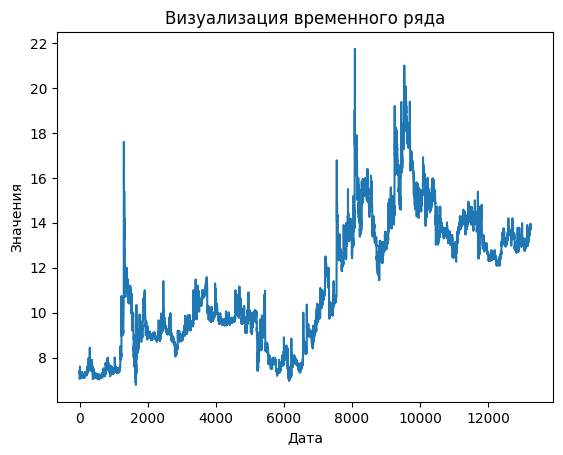

Ряд нестационарен
              Test Statistic P-value  Stationary     Conclusion
0              ADF   -1.3583  0.6021       False  Нестационарен
1             KPSS    1.2573  0.0100       False  Нестационарен
2  Phillips-Perron   -1.3110  0.6241       False  Нестационарен


In [22]:
stat = StationarityTester(alpha=0.05)
results1 = stat.run_all_tests(data['High'])
print(tester1.get_stationarity_summary())